# Kaggle Titanic dataset

This is my second attempt at tackling Kaggle's Titanic challenge. The objective is to predict which passengers survive and which ones don't based on data including passenger class, ticket price, age, sex, and names. 

**So far the predictions from the notebook score 76%**

#### Import required packages

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### Import training and testing data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Explore training data

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


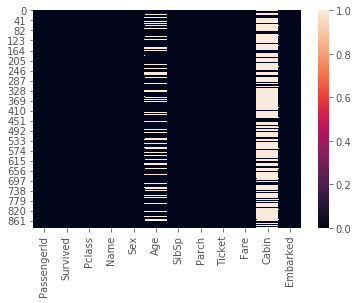

In [5]:
sns.heatmap(train.isna())

In [6]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It is conceivable that the null values in the the `Cabin` feature means that the person didn't actually have a cabin seeing as though the ticket price seems to be lower for people with a `NaN` value. Can investigate this in a number of ways:

#### Feature engineering

In [7]:
# Broadcasts True if non null value is found
train['has_cabin'] = ~train.Cabin.isnull()

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False


Map boolean values to 0 and 1 in new column

In [9]:
train['has_cabin_map'] = train['has_cabin'].map({False: 0, True:1})

Map `Sex` to 0 and 1

In [10]:
train['Sex_map'] = train['Sex'].map({'male': 0, 'female':1})

Combine features `SibSp` and `Parch` into `Family`

In [11]:
train['Family'] = train['SibSp'] + train['Parch']

Drop unneeded columns

In [12]:
train.drop(['Sex', 'SibSp', 'Parch', 'Ticket', 'PassengerId', 'Cabin', ], axis=1, inplace=True)

In [13]:
train.head()

,Survived,Pclass,Name,Age,Fare,Embarked,has_cabin,has_cabin_map,Sex_map,Family
0,0,3,"Braund, Mr. Owen Harris",22.0,7.2500,S,False,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,C,True,1,1,1
2,1,3,"Heikkinen, Miss. Laina",26.0,7.9250,S,False,0,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,53.1000,S,True,1,1,1
4,0,3,"Allen, Mr. William Henry",35.0,8.0500,S,False,0,0,0


Passenger names are not important but their titles could be. These need to be extracted and standardized.

In [14]:
train['Title'] = train.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

In [15]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [16]:
train['Title'] = train['Title'].replace({'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss'})

In [17]:
train['Title'] = train['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'], 'Unique')

In [18]:
train.drop('Name', axis=1, inplace=True)

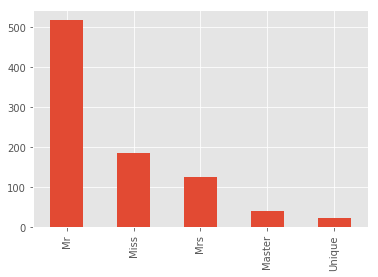

In [19]:
train['Title'].value_counts().plot(kind='bar')

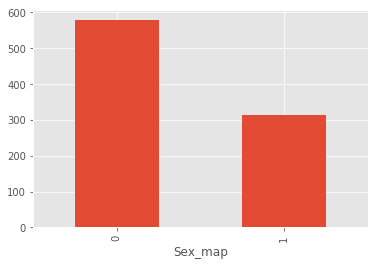

In [20]:
_ = train.groupby('Sex_map')['Survived'].count().plot(kind='bar')

There were more male fatalities than female ones

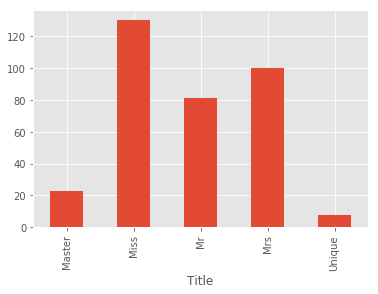

In [21]:
train.groupby('Title')['Survived'].sum().plot(kind='bar')

In [22]:
train['age_groups'] = pd.cut(train.Age, 4)

### Dealing with missing values

In [23]:
# Fill missing fare values with the column's median value
train['Fare'] = train.Fare.fillna(train.Fare.median())

In [24]:
# Fill missing age values with the column's median value
train['Age'] = train.Age.fillna(train.Age.median())

In [25]:
# Fill missing values with S, which is most common in the column
train['Embarked'] = train.Embarked.fillna('S')

Create bins for numerical data

In [26]:
train['Fare_binned'] = pd.qcut(train.Fare, 5, labels=False)

In [27]:
train.drop(['has_cabin_map', 'Fare'], axis=1, inplace=True)

#### Create a column contains True if a passenger in under 18. This group is one that is most likely to survive. 

In [28]:
data2 = []
for x in train['Age']:
    if x <= 18:
        data2.append(True)
    else:
        data2.append(False)

In [29]:
train['under_18'] = data2

In [30]:
train.drop('age_groups', axis=1, inplace=True)

In [31]:
train['Age'] = train.Age / 100

In [32]:
train.head()

,Survived,Pclass,Age,Embarked,has_cabin,Sex_map,Family,Title,Fare_binned,under_18
0,0,3,0.22,S,False,0,1,Mr,0,False
1,1,1,0.38,C,True,1,1,Mrs,4,False
2,1,3,0.26,S,False,1,0,Miss,1,False
3,1,1,0.35,S,True,1,1,Mrs,4,False
4,0,3,0.35,S,False,0,0,Mr,1,False


#### Create dummy variables for categorical data

In [33]:
final_training_data = pd.get_dummies(train, drop_first=True)

In [34]:
final_training_data.head()

,Survived,Pclass,Age,has_cabin,Sex_map,Family,Fare_binned,under_18,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Unique
0,0,3,0.22,False,0,1,0,False,0,1,0,1,0,0
1,1,1,0.38,True,1,1,4,False,0,0,0,0,1,0
2,1,3,0.26,False,1,0,1,False,0,1,1,0,0,0
3,1,1,0.35,True,1,1,4,False,0,1,0,0,1,0
4,0,3,0.35,False,0,0,1,False,0,1,0,1,0,0


### Engineer test set for predicting

In [35]:
def format_data(dataset):
    dataset['has_cabin'] = ~dataset.Cabin.isnull()
    dataset['Sex_map'] = dataset['Sex'].map({'male': 0, 'female':1})
    dataset['Family'] = dataset['SibSp'] + dataset['Parch']
    dataset['Title'] = dataset.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
    dataset['Title'] = dataset['Title'].replace({'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Master': 'Mr'})
    dataset['Title'] = dataset['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 
                                                 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'], 'Unique')
    dataset['Fare'] = dataset.Fare.fillna(dataset.Fare.median())
    dataset['Age'] = dataset.Age.fillna(dataset.Age.median())
    dataset['Age'] = dataset.Age / 100
    dataset['Embarked'] = dataset.Embarked.fillna('S')
    dataset['Fare_binned'] = pd.qcut(dataset.Fare, 5, labels=False)
    data2 = []
    for x in dataset['Age']:
        if x <= 18:
            data2.append(True)
        else:
            data2.append(False)
    dataset['under_18'] = data2
    dataset.drop(['Cabin', 'Sex', 'SibSp', 'Parch', 'Name', 'Fare', 'Ticket'], axis=1, inplace=True)
    return dataset

In [36]:
# Call the above function on the test data to format it 
test_final = format_data(test)

In [37]:
test_final.columns

Index(['PassengerId', 'Pclass', 'Age', 'Embarked', 'has_cabin', 'Sex_map',
       'Family', 'Title', 'Fare_binned', 'under_18'],
      dtype='object')

### Split training data into training and testing sets

In [38]:
labels = final_training_data['Survived']

In [39]:
data = final_training_data.iloc[:,1:]

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=0)

### Separate PassengerId column from test_final and add dummy variables

In [42]:
passenger_id = test_final['PassengerId']

In [43]:
test_final = test_final.drop('PassengerId', axis=1)

In [44]:
test_final_dum = pd.get_dummies(test_final, drop_first=True)

## Import algorithms to infer survival 

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

### KNeighborsClassifier

In [97]:
knn = KNeighborsClassifier(n_neighbors=3)

In [98]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [99]:
print('Training score: {}'.format(knn.score(X_train, y_train)))
print('Testing score: {}'.format(knn.score(X_test, y_test)))

Training score: 0.8832335329341318
Testing score: 0.8026905829596412


### LogisticRegression

In [119]:
logreg = LogisticRegression(solver='lbfgs',C=10,random_state=0, max_iter=10000) #C = 100

In [120]:
logreg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [121]:
print('Training score: {}'.format(logreg.score(X_train, y_train)))
print('Testing score: {}'.format(logreg.score(X_test, y_test)))

Training score: 0.8398203592814372
Testing score: 0.8430493273542601


### RandomForestClassifier

In [215]:
rf = RandomForestClassifier(max_depth=6, n_estimators=100, random_state=0)

In [216]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [217]:
print('Training score: {}'.format(rf.score(X_train, y_train)))
print('Testing score: {}'.format(rf.score(X_test, y_test)))

Training score: 0.8547904191616766
Testing score: 0.8430493273542601


### GradientBoostingClassifier

In [122]:
gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)

In [123]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [124]:
print('Training score: {}'.format(gbc.score(X_train, y_train)))
print('Testing score: {}'.format(gbc.score(X_test, y_test)))

Training score: 0.8817365269461078
Testing score: 0.8295964125560538


### MLPClassifier

In [110]:
mlp = MLPClassifier(max_iter=1000, hidden_layer_sizes=[100,100], alpha=0.0001, activation='tanh')

In [111]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[100, 100], learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [112]:
print('Training score: {}'.format(mlp.score(X_train, y_train)))
print('Testing score: {}'.format(mlp.score(X_test, y_test)))

Training score: 0.8488023952095808
Testing score: 0.8430493273542601


### DecisionTreeClassifier

In [87]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)

In [88]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [89]:
print('Training score: {}'.format(tree.score(X_train, y_train)))
print('Testing score: {}'.format(tree.score(X_test, y_test)))

Training score: 0.8458083832335329
Testing score: 0.820627802690583


### LinearSVC

In [47]:
svc = LinearSVC(max_iter=100000, C=20, random_state=0)

In [48]:
svc.fit(X_train, y_train)

LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [49]:
print('Training score: {}'.format(svc.score(X_train, y_train)))
print('Testing score: {}'.format(svc.score(X_test, y_test)))

Training score: 0.8368263473053892
Testing score: 0.8340807174887892


### Make predictions with LogReg and export

In [77]:
pred_logreg = logreg.predict(test_final_dum)

In [82]:
submission = pd.DataFrame({'PassengerId': passenger_id, 'Survived': pred_logreg })

In [84]:
submission.set_index('PassengerId', inplace=True)

In [86]:
submission.to_csv('sub4.csv')

### Make predictions with MLP and export

In [101]:
pred_mlp = mlp.predict(test_final_dum)

In [102]:
submission_mlp = pd.DataFrame({'PassengerId': passenger_id, 'Survived': pred_mlp })

In [103]:
submission_mlp.set_index('PassengerId', inplace=True)

In [104]:
submission.to_csv('submlp.csv')